# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [12]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2026/data_forecast_2026_silver/ingresos_membresia_7_dias_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-27 00:00:00 a 2025-11-30 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,391.0,2022-07-27,391.0
1,1,391.0,2022-07-31,391.0
2,1,391.0,2022-08-09,391.0
3,6,2346.0,2022-08-13,2346.0
4,5,1955.0,2022-08-14,1955.0


Filtro para obtener muestra de datos

In [13]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [14]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.15,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [15]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1562 2026-11-26
1563 2026-11-27
1564 2026-11-28
1565 2026-11-29
1566 2026-11-30


Paso 5: Realizar la Predicción (Forecast)

In [16]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds         yhat   yhat_lower   yhat_upper
1562 2026-11-26  3895.529141  1542.665321  6163.745697
1563 2026-11-27  3773.122005  1493.387581  6413.777805
1564 2026-11-28  4389.995658  2038.740605  6864.424891
1565 2026-11-29  5122.755173  2702.697473  7558.765536
1566 2026-11-30  3848.106930  1499.825470  6500.948839


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

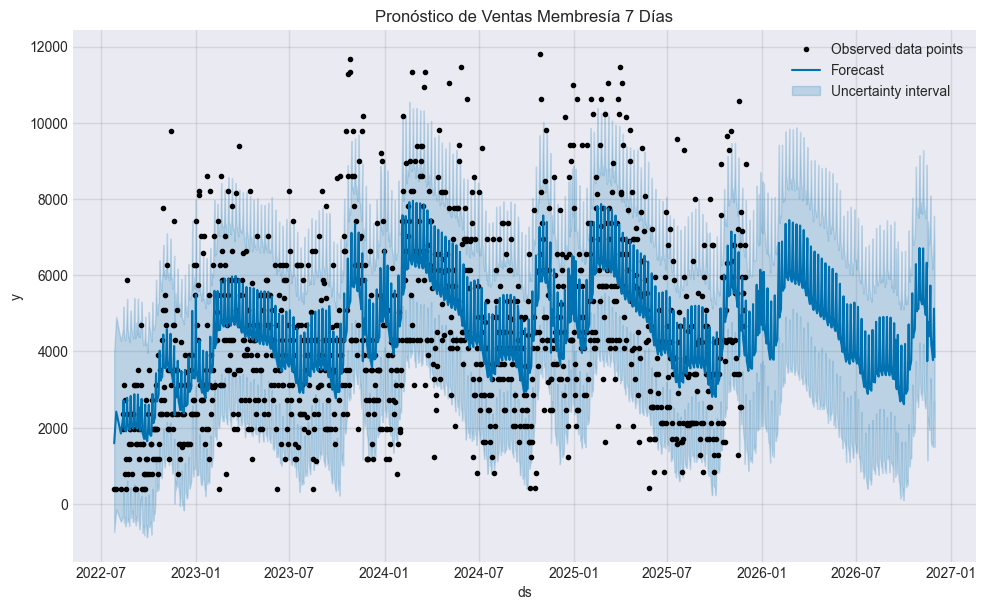

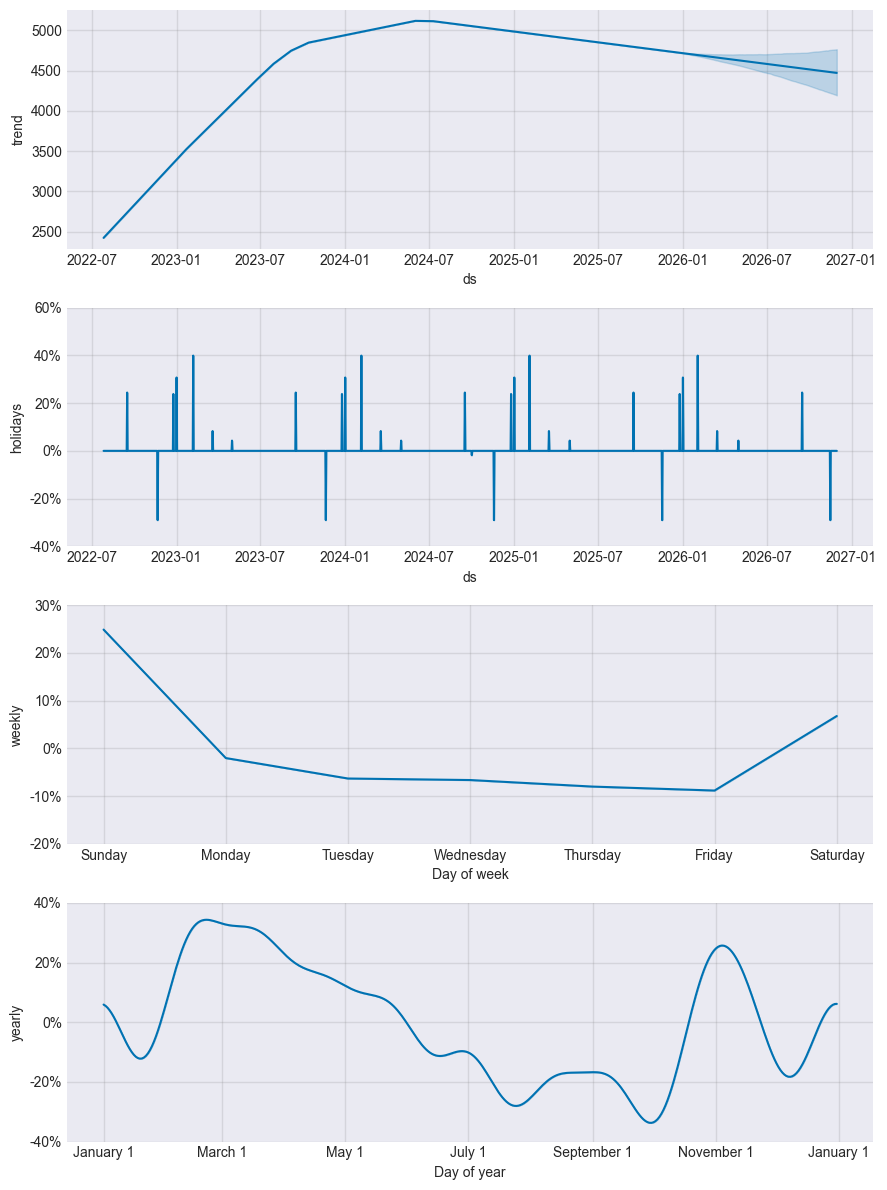

In [17]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas Membresía 7 Días")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [18]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month       yhat  yhat_lower  yhat_upper
0   2022-07    4009.99     -884.81     8895.02
1   2022-08   38969.53    -4242.08    82868.71
2   2022-09   59051.29    -9863.18   127246.66
3   2022-10   82238.23    10975.29   152980.49
4   2022-11  103053.09    31179.55   175929.21
5   2022-12   91304.45    17867.97   164169.75
6   2023-01  104863.64    28197.41   179609.81
7   2023-02  131128.63    62340.01   200505.68
8   2023-03  153809.99    77744.79   230300.38
9   2023-04  141875.38    68960.31   214438.14
10  2023-05  139242.51    63030.00   214525.57
11  2023-06  118385.75    45032.33   191290.88
12  2023-07  111784.12    35842.60   186634.01
13  2023-08  116080.89    41803.54   192082.42
14  2023-09  110397.05    36890.58   184622.91
15  2023-10  140456.53    65123.32   216252.22
16  2023-11  162518.49    88851.74   234794.17
17  2023-12  141921.65    65762.29   217232.95
18  2024-01  147670.20    72066.69   222956.37
19  2024-02  184807.78   114262.36   255869.68
20  2024-03  

In [19]:
monthly_sales.to_csv("../data/data_forecast_2026/data_forecast_2026_gold/forecast_7_dias_2026_monthly.csv")

In [20]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/3 [00:00<?, ?it/s]

13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 1/3 [00:00<00:00,  2.53it/s]13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 2/3 [00:00<00:00,  2.52it/s]13:13:13 - cmdstanpy - INFO - Chain [1] start processing
13:13:13 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 3/3 [00:01<00:00,  2.48it/s]

  horizon         rmse      mape
0  9 days  2041.544013  0.605471
1 10 days  2072.322299  0.560040
2 11 days  2105.595201  0.552387
3 12 days  1936.172418  0.499208
4 13 days  1775.347476  0.432366
